In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
from pandas import Series
from sklearn.metrics import mean_squared_error
from datetime import datetime 

In [2]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from fbprophet import Prophet

In [3]:
import warnings
warnings.filterwarnings('ignore')

### GLOBAL VARIABLES

In [4]:
INPUT_PATH = '../../../data/processed'
INPUT_FILE_NAME = 'dataproc_v001'
OUTPUT_PATH = '../../../models/prophet/hyperparameters/'
HYPERPARAM_NAME = 'best_hyperparam_sarima_r'
LOG_NAME = 'gsearch_arima_logs_r'
OUTPUT_FILE_NAME = 'gsearch_sarima_logs_d'
NRUN = 2
DAYS_PRED = 28
METRIC = 'rmse'

### FUNCTIONS

In [5]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, 
                    trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [7]:
# score a model, return None on failure
def score_model(train, test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(train, test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                tic = datetime.now()
                result = walk_forward_validation(train, test, cfg)
                toc = datetime.now()
        except:
            result = None
    # check for an interesting result
    if result is not None:
        #print(' > Model[%s] %.3f' % (key, result))
        diff_time_run = toc - tic
        line = datetime.now().strftime("%d/%m/%Y") + ", " + str(key) + ", " + METRIC + ", " + str(result) + ", " + str(diff_time_run.total_seconds()/60) + "\n"
        
        # save into log file
        with open(f'{OUTPUT_PATH}/{LOG_NAME}{NRUN}.csv','a+') as f:
            f.write(line)
        
    return (key, result)

In [8]:
# grid search configs
def grid_search(train, test, cfg, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(train, test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(train, test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

### LOAD DATASET

data = pd.read_pickle(f'{INPUT_PATH}/{INPUT_FILE_NAME}.pkl')

In [9]:
data = pd.read_csv(f'{INPUT_PATH}/{INPUT_FILE_NAME}.csv', sep=';')

In [10]:
data = data[data.part == 'train'] # select only train data

In [11]:
date_cutoff = data.d.max() - DAYS_PRED

X_train = data[data.d <= date_cutoff]

X_test = data[data.d > date_cutoff]

del data

In [20]:
ID = 'HOBBIES_1_001_CA_1_validation'

In [16]:
train = X_train[X_train.id == ID]

In [17]:
train = train[['date', 'demand']]

In [18]:
train.columns = ['ds', 'y']

with open(f'{OUTPUT_PATH}/{LOG_NAME}{NRUN}.csv','w+') as f:
    f.write(f"date, params, metric, score, time [min] \n")

In [19]:
train.head()

,ds,y
0,2014-05-23,1
30490,2014-05-24,0
60980,2014-05-25,0
91470,2014-05-26,0
121960,2014-05-27,1


## TRAIN MODEL

### model configs
cfg_list = sarima_configs()

In [33]:
test = X_test[X_test.id == ID].pivot(index='id', columns='date', values='demand').values

nrows = test.shape[0]

ridx = np.random.choice(nrows, size=100, replace=False)

train.drop('state_id', axis=1, inplace=True)

In [67]:
m = Prophet(yearly_seasonality = True,seasonality_prior_scale=0.1)
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [68]:
future = m.make_future_dataframe(periods=DAYS_PRED)
future.tail()

,ds
698,2016-04-20
699,2016-04-21
700,2016-04-22
701,2016-04-23
702,2016-04-24


In [69]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
698,2016-04-20,0.558581,-0.562409,1.650706
699,2016-04-21,0.375417,-0.709979,1.565497
700,2016-04-22,0.606829,-0.526729,1.648254
701,2016-04-23,0.918182,-0.159716,2.009337
702,2016-04-24,0.585335,-0.528075,1.692920


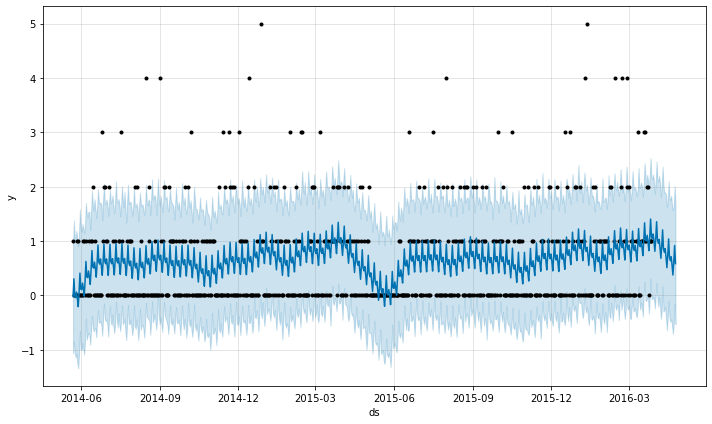

In [70]:
fig1 = m.plot(forecast)

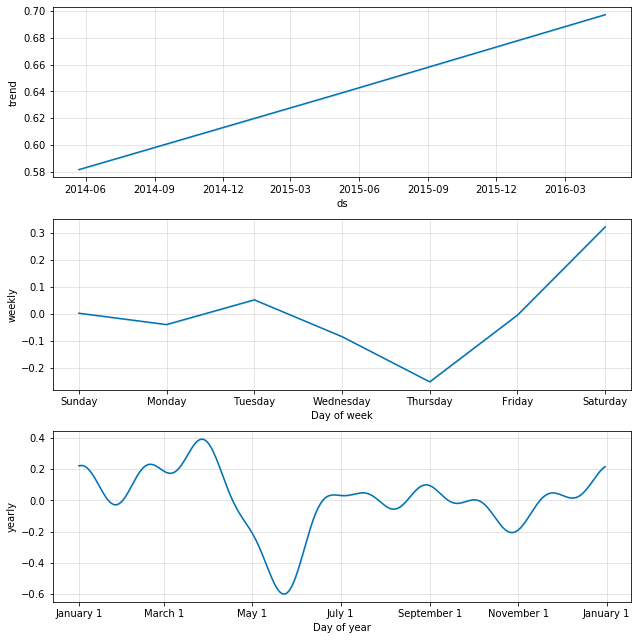

In [71]:
fig2 = m.plot_components(forecast)

In [45]:
pred = forecast.iloc[-DAYS_PRED:,-1:]

In [53]:
y_hat = [i[0] for i in pred.values]

In [61]:
rmse(test.tolist()[0],y_hat)

1.176274813790614

In [ ]:
test = test[ridx, :] # select only some rows to test because take to many time to evaluate the model

In [ ]:
# grid search
scores = grid_search(train, test, cfg_list)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)